In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample
from joblib import dump, load
import pickle

In [2]:
# df = pd.read_csv('../data/processed/merged_financials_news.csv')
df = pd.read_csv('../data/processed/preprocessed_features_3.csv')

In [3]:
df.head()

,symbol,date,debt_to_equity,marketCap,ROA,price_to_earnings,current_ratio,quick_ratio,interest_coverage,net_income_to_sales,...,totalEsg,region_east_asia_n_pacific,region_europe_n_central_asia,region_latin_america_n_caribbean,region_north_america,region_south_asia,region_sub_saharan_africa,companySize_Large-Cap,companySize_Mid-Cap,companySize_Small-Cap
0,000270.KS,2024-12-31,-0.157335,1.942613,0.544856,-0.064354,0.063022,-0.005920,0.216956,-0.198089,...,24.55,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0005.HK,2024-12-31,0.097658,0.592456,-0.685504,-0.053918,0.170119,0.102114,-0.110233,1.104910,...,24.22,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,000660.KS,2024-12-31,-0.097653,2.493922,1.299417,-0.067036,0.210551,0.021879,-0.067338,0.829555,...,17.67,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,005380.KS,2024-12-31,0.108563,2.065202,-0.320274,-0.064337,-0.856954,-0.212365,-0.013995,-0.294273,...,28.31,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,005930.KS,2024-12-31,-0.160820,2.945278,0.039414,-0.063231,0.861259,0.302301,-0.008727,-0.095363,...,19.41,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Data Preprocessing

In [4]:
df.columns[df.isna().any()].tolist()

[]

In [5]:
# null values in the sentiment columns are due to zero division errors, so they can be filled with 0
df['sentiment_ratio_extremes'] = df['sentiment_ratio_extremes'].fillna(0)
df.columns[df.isna().any()].tolist()

[]

In [7]:
# drop the remaining metadata columns
df_clean = df.drop(columns=['date', 'symbol'])

In [8]:
# create a combined stratification variable from region and size
def process_strata(x, df):
    return '_'.join([
        next((col.replace('region_', '') for col in df.columns if col.startswith('region_') and x[col] == 1), ''),
        next((col.replace('companySize_', '') for col in df.columns if col.startswith('companySize_') and x[col] == 1), '')
    ])

In [9]:
# print columns with static values
df_clean.columns[df_clean.nunique() == 1].tolist()

[]

In [11]:
df_clean['strat_var'] = df_clean.apply(lambda x: process_strata(x, df_clean), axis=1)

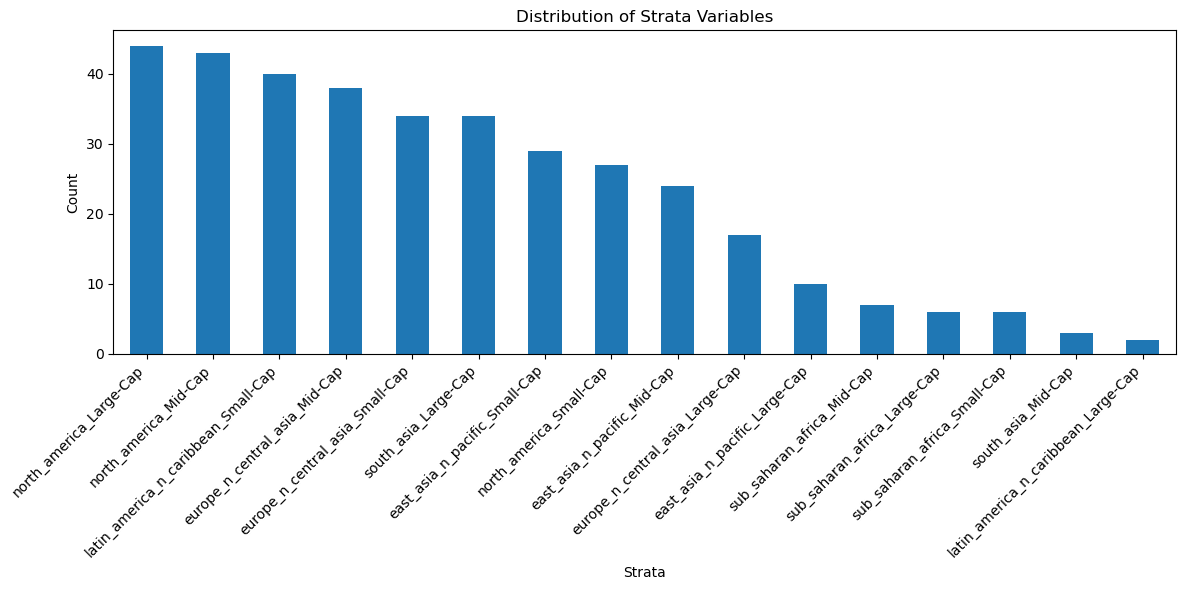

In [12]:
# Create figure with larger size
plt.figure(figsize=(12, 6))

# Plot value counts
df_clean['strat_var'].value_counts().plot(kind='bar')

# Customize the plot
plt.title('Distribution of Strata Variables')
plt.xlabel('Strata')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Data Construction

## Baseline Data Definition

This represents a less diverse, status quo scenario. This could be:
- the dataset in its original, imbalanced form 
- a deliberately constrained subset. 

In line with common ESG datasets that are skewed towards large companies in developed regions, we construct the baseline to have a limited diversity in region and size. For example, the baseline training data may be dominated by North American and European firms (the most represented in typical ESG data) and by large-cap companies, with fewer or no examples from other regions or smaller firms. This baseline reflects a case where selection bias is present 

In [13]:
# construct baselines with limited diversity and constrained regions
baseline = df_clean.copy()
baseline_constrained = df_clean.loc[((df_clean['companySize_Large-Cap'] == 1 ) | (df_clean['companySize_Mid-Cap'] == 1)) & ((df_clean['region_north_america'] == 1) | (df_clean['region_europe_n_central_asia'] == 1))]

In [14]:
baseline.shape, baseline_constrained.shape

((364, 55), (142, 55))

In [15]:
baseline_constrained['strat_var'].value_counts(dropna=False).sort_index()

strat_var
europe_n_central_asia_Large-Cap    17
europe_n_central_asia_Mid-Cap      38
north_america_Large-Cap            44
north_america_Mid-Cap              43
Name: count, dtype: int64

## Diversified Dataset

The diversified dataset is constructed to be globally representative, incorporating a wide range of regions and company sizes. We sample or weight the data such that all major geographic regions (e.g. North America, Europe & Central Asia, East Asia & Pacific, Latin America, Middle East & Africa, South Asia, Sub-Saharan Africa) and firm sizes (small-cap, mid-cap, large-cap) are included in appreciable proportions

In [16]:
def build_diversified_dataset(df, strata_key="strat_var", 
                              target_sample_size: str = 'max',
                              random_state: int = 42):
    """
    Returns a diversified DataFrame where each group defined by strata_cols
    has been up‑sampled or down‑sampled to the same size.

    Parameters
    ----------
    df : pd.DataFrame
        Preprocessed DataFrame (no date columns, all features encoded).
    strata_cols : tuple of str
        Column names to define each stratum, e.g. ('region', 'companySize').
    target_sample_size : 'max' | 'min' | int
        - 'max': up-sample all groups to the size of the largest group.
        - 'min': down-sample all groups to the size of the smallest group.
        - int: sample exactly this many rows per group (must be <= max and >= min).
    random_state : int
        For reproducibility of sampling.

    Returns
    -------
    pd.DataFrame
        Diversified dataset.
    """
    
    # Compute counts per stratum
    counts = df[strata_key].value_counts()
    
    # Determine target sampling size
    if target_sample_size == 'max':
        n_target = counts.max()
    elif target_sample_size == 'min':
        n_target = counts.min()
    elif isinstance(target_sample_size, int):
        n_target = target_sample_size
        if n_target < counts.min() or n_target > counts.max():
            raise ValueError(f"target_sample_size must be between {counts.min()} and {counts.max()}")
    else:
        raise ValueError("target_sample_size must be one of {'max','min'} or an integer")
    
    # Resample each group
    frames = []
    for stratum, grp_count in counts.items():
        grp = df[df[strata_key] == stratum]
        if grp_count > n_target:
            # Down‑sample without replacement
            grp_resampled = grp.sample(n=n_target, replace=False, random_state=random_state)
        elif grp_count < n_target:
            # Up‑sample with replacement
            grp_resampled = grp.sample(n=n_target, replace=True, random_state=random_state)
        else:
            # Already at target size
            grp_resampled = grp
        frames.append(grp_resampled)
    
    diversified = pd.concat(frames, axis=0).reset_index(drop=True)
    # diversified.drop(columns=strata_key, inplace=True)
    return diversified

In [17]:
# Option A: up‑sample minority strata to match the largest group
diversified_max = build_diversified_dataset(df_clean, target_sample_size='max')
print("Diversified (to max) shape:", diversified_max.shape)
# print(diversified_max.groupby('strat_var').size())

# Option B: down‑sample majority strata to match the smallest group
diversified_min = build_diversified_dataset(df_clean, target_sample_size='min')
print("Diversified (to min) shape:", diversified_min.shape)
# print(diversified_min.groupby('strat_var').size())

# Option C: choose a custom size, e.g. median group size
median_n = int(df_clean.groupby('strat_var').size().median())
diversified_med = build_diversified_dataset(df_clean, target_sample_size=median_n)
print(f"Diversified (to median={median_n}) shape:", diversified_med.shape)
# print(diversified_med.groupby('strat_var').size())

Diversified (to max) shape: (704, 55)
Diversified (to min) shape: (32, 55)
Diversified (to median=25) shape: (400, 55)


# Experimental Setup

## Within-Sample Evaluation

Traditional evaluation where training and test data are drawn from the same distribution. Data is split into training and test sets using stratified random sampling.
Stratification is done on key group variables (region and size) so that the test set contains a similar distribution of regions and company sizes as the training set.

This within-sample test measures how well the model fits the data it’s generally expected to see (i.i.d. scenario) and provides a baseline performance on familiar contexts.

In [18]:
def within_sample_eval(df, strata_key="strat_var", test_size=0.2, random_state=42, show_stats=False):
    """
    Performs stratified train/test split while maintaining distribution of region and size.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing features and strata_key
    strata_key : str
        Column name for stratification variable
    test_size : float
        Proportion of dataset to include in the test split
    random_state : int
        Random seed for reproducibility
    show_stats : bool
        Whether to print distribution statistics
        
    Returns
    -------
    dict
        Dictionary containing train/test splits for the 
    """
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    splits = {}
    
    for train_idx, test_idx in splitter.split(df, df[strata_key]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()
        
        if show_stats:
            print("\nDataset sizes:")
            print(f"Training set: {len(train_df)} samples")
            print(f"Test set: {len(test_df)} samples")
            
            # Compare distributions
            print("\nStrata distribution:")
            train_dist = train_df[strata_key].value_counts(normalize=True)
            test_dist = test_df[strata_key].value_counts(normalize=True)
            
            comparison = pd.DataFrame({
                'Train %': train_dist * 100,
                'Test %': test_dist * 100
            }).round(2)
            print(comparison)
            
        # Drop stratification variable after checking distributions
        train_df = train_df.drop(columns=strata_key)
        test_df = test_df.drop(columns=strata_key)
        
        splits['within_sample'] = {
            'train': train_df,
            'test': test_df,
            'train_size': len(train_df),
            'test_size': len(test_df)
        }
        
    return splits

In [19]:
# Example usage:
print("Baseline Dataset Within-Sample Split:")
baseline_splits = within_sample_eval(baseline, show_stats=True)

print("\nDiversified Dataset Within-Sample Split:")
diversified_splits = within_sample_eval(diversified_med, show_stats=True)

# Access the splits using the dictionary structure
train_data = baseline_splits['within_sample']['train']
test_data = baseline_splits['within_sample']['test']

Baseline Dataset Within-Sample Split:

Dataset sizes:
Training set: 291 samples
Test set: 73 samples

Strata distribution:
                                     Train %  Test %
strat_var                                           
east_asia_n_pacific_Large-Cap           2.75    2.74
east_asia_n_pacific_Mid-Cap             6.53    6.85
east_asia_n_pacific_Small-Cap           7.90    8.22
europe_n_central_asia_Large-Cap         4.81    4.11
europe_n_central_asia_Mid-Cap          10.31   10.96
europe_n_central_asia_Small-Cap         9.28    9.59
latin_america_n_caribbean_Large-Cap     0.69     NaN
latin_america_n_caribbean_Small-Cap    11.00   10.96
north_america_Large-Cap                12.03   12.33
north_america_Mid-Cap                  11.68   12.33
north_america_Small-Cap                 7.56    6.85
south_asia_Large-Cap                    9.28    9.59
south_asia_Mid-Cap                      0.69    1.37
sub_saharan_africa_Large-Cap            1.72    1.37
sub_saharan_africa_Mid-Cap   

## Region Hold Out

In each run, we exclude all companies from a particular geographic region from the training set, and reserve them as a hold-out test set. For instance, we might train a model using data from all regions except East Asia & Pacific, and then test it on the East Asia & Pacific companies’ data to see how well the model generalizes to that unseen region. 

In [20]:
def region_holdout_eval(df, strata_key="strat_var", show_stats=False):
    """
    Performs leave-one-region-out evaluation by iteratively holding out each region
    as a test set and training on the remaining regions.
    
    Parameters
    ----------
    df : pd.DataFrame
        Preprocessed DataFrame containing region columns and strata_key
    strata_key : str
        Column name for stratification variable
        
    Returns
    -------
    dict
        Dictionary containing train/test splits for each held-out region
    """
    # Get all region columns
    all_region_cols = [col for col in df.columns if col.startswith('region_')]
    holdout_splits = {}

    # Identify region columns that have no data (sum is 0)
    region_cols_to_drop = []
    for col in all_region_cols:
        if df[col].sum() == 0:
            region_cols_to_drop.append(col)

    # Drop the region columns with no data
    if region_cols_to_drop:
        print(f"Dropping region columns with no data: {region_cols_to_drop}")
        df = df.drop(columns=region_cols_to_drop)

    # Update the list of region columns to only include those that had data
    region_cols = [col for col in all_region_cols if col not in region_cols_to_drop]

    # Check if there are any valid regions left to process
    if not region_cols:
        print("No region columns with data found after filtering. Returning empty splits.")
        return {}
    
    # Perform leave-one-region-out splits
    for region_col in region_cols:
        region_name = region_col.replace('region_', '')
        
        # Create train/test split
        test_mask = df[region_col] == 1
        train_df = df[~test_mask].copy()
        test_df = df[test_mask].copy()
        
        # Drop stratification variable if present
        if strata_key in train_df.columns:
            train_df = train_df.drop(columns=[strata_key])
            test_df = test_df.drop(columns=[strata_key])
            
        holdout_splits[region_name] = {
            'train': train_df,
            'test': test_df,
            'train_size': len(train_df),
            'test_size': len(test_df)
        }
        
        print(f"\nHold-out region: {region_name}")
        print(f"Training set size: {len(train_df)}")
        print(f"Test set size: {len(test_df)}")
        
        # Print region distribution in training set
        if show_stats:
            print("\nRegion distribution in training set:")
            for r in region_cols:
                pct = train_df[r].mean() * 100
                if pct > 0:
                    print(f"{r.replace('region_', '')}: {pct:.1f}%")
                    
    return holdout_splits

## Company-Size Hold Out

We categorize companies into size classes (Small-Cap, Mid-Cap, Large-Cap, as provided in the dataset) and train models excluding one category. For example, train on only large and mid-cap firms, and test on all the small-cap firms (which the model has never seen). 

In [21]:
def size_holdout_eval(df, strata_key="strat_var", show_stats=False):
    """
    Performs leave-one-size-out evaluation by iteratively holding out each company size
    as a test set and training on the remaining sizes.
    
    Parameters
    ----------
    df : pd.DataFrame
        Preprocessed DataFrame containing company size columns and strata_key
    strata_key : str
        Column name for stratification variable
        
    Returns
    -------
    dict
        Dictionary containing train/test splits for each held-out size category
    """
    # Get all company size columns
    all_size_cols = [col for col in df.columns if col.startswith('companySize_')]
    holdout_splits = {}

    # Identify size columns that have no data (sum is 0)
    size_cols_to_drop = []
    for col in all_size_cols:
        if df[col].sum() == 0:
            size_cols_to_drop.append(col)

    # Drop the size columns with no data
    if size_cols_to_drop:
        print(f"Dropping size columns with no data: {size_cols_to_drop}")
        df = df.drop(columns=size_cols_to_drop)

    # Update the list of size columns to only include those that had data
    size_cols = [col for col in all_size_cols if col not in size_cols_to_drop]

    # Check if there are any valid sizes left to process
    if not size_cols:
        print("No size columns with data found after filtering. Returning empty splits.")
        return {}
    
    # Perform leave-one-size-out splits
    for size_col in size_cols:
        size_name = size_col.replace('companySize_', '')
        
        # Create train/test split
        test_mask = df[size_col] == 1
        train_df = df[~test_mask].copy()
        test_df = df[test_mask].copy()
        
        # Drop stratification variable if present
        if strata_key in train_df.columns:
            train_df = train_df.drop(columns=[strata_key])
            test_df = test_df.drop(columns=[strata_key])
            
        holdout_splits[size_name] = {
            'train': train_df,
            'test': test_df,
            'train_size': len(train_df),
            'test_size': len(test_df)
        }
        
        print(f"\nHold-out size: {size_name}")
        print(f"Training set size: {len(train_df)}")
        print(f"Test set size: {len(test_df)}")
        
        # Print size distribution in training set
        if show_stats:
            print("\nSize distribution in training set:")
            for s in size_cols:
                pct = train_df[s].mean() * 100
                if pct > 0:
                    print(f"{s.replace('companySize_', '')}: {pct:.1f}%")
            
            # Also show region distribution to check for any bias
            region_cols = [col for col in df.columns if col.startswith('region_')]
            print("\nRegion distribution in training set:")
            for r in region_cols:
                pct = train_df[r].mean() * 100
                if pct > 0:
                    print(f"{r.replace('region_', '')}: {pct:.1f}%")
    
    return holdout_splits

In [22]:
# Create holdout splits for both baseline and diversified datasets
print("Baseline Dataset Size Holdouts:")
baseline_size_holdouts = size_holdout_eval(baseline, show_stats=True)

print("\nDiversified Dataset Size Holdouts:")
diversified_size_holdouts = size_holdout_eval(diversified_med, show_stats=True)

# Example: Using Small-Cap holdout
size = 'Small-Cap'
train_data = diversified_size_holdouts[size]['train']
test_data = diversified_size_holdouts[size]['test']

Baseline Dataset Size Holdouts:

Hold-out size: Large-Cap
Training set size: 251
Test set size: 113

Size distribution in training set:
Mid-Cap: 45.8%
Small-Cap: 54.2%

Region distribution in training set:
east_asia_n_pacific: 21.1%
europe_n_central_asia: 28.7%
latin_america_n_caribbean: 15.9%
north_america: 27.9%
south_asia: 1.2%
sub_saharan_africa: 5.2%

Hold-out size: Mid-Cap
Training set size: 249
Test set size: 115

Size distribution in training set:
Large-Cap: 45.4%
Small-Cap: 54.6%

Region distribution in training set:
east_asia_n_pacific: 15.7%
europe_n_central_asia: 20.5%
latin_america_n_caribbean: 16.9%
north_america: 28.5%
south_asia: 13.7%
sub_saharan_africa: 4.8%

Hold-out size: Small-Cap
Training set size: 228
Test set size: 136

Size distribution in training set:
Large-Cap: 49.6%
Mid-Cap: 50.4%

Region distribution in training set:
east_asia_n_pacific: 14.9%
europe_n_central_asia: 24.1%
latin_america_n_caribbean: 0.9%
north_america: 38.2%
south_asia: 16.2%
sub_saharan_af

# Experiment Data Creation

In [23]:
def create_experiment_datasets(df, random_state=42):
    """
    Creates all datasets needed for experiments, including baseline and diversified versions
    with different evaluation splits.
    
    Parameters
    ----------
    df : pd.DataFrame
        Preprocessed DataFrame with all features and strata variables
    random_state : int
        For reproducibility
        
    Returns
    -------
    dict
        Nested dictionary containing all dataset variants and their splits
    """
    datasets = {
        'baselines': {},
        'diversified': {}
    }
    
    # Create baseline datasets
    baselines = {
        'full': df.copy(),  # Original imbalanced dataset
        'constrained': df.loc[
            ((df['companySize_Large-Cap'] == 1) | (df['companySize_Mid-Cap'] == 1)) & 
            ((df['region_north_america'] == 1) | 
             (df['region_europe_n_central_asia'] == 1))
        ]  # Limited to large-cap companies in developed regions
    }
    
    # Create splits for each baseline
    for baseline_name, baseline_data in baselines.items():
        datasets['baselines'][baseline_name] = {
            'original_data': baseline_data,
            'within_sample': within_sample_eval(
                baseline_data, 
                show_stats=False
            ),
            'region_holdout': region_holdout_eval(
                baseline_data, 
                show_stats=False
            ),
            'size_holdout': size_holdout_eval(
                baseline_data, 
                show_stats=False
            )
        }
    
    # Create diversified datasets with different balancing strategies
    diversified_variants = {
        'max_balanced': build_diversified_dataset(
            df, target_sample_size='max', 
            random_state=random_state
        ),
        # 'min_balanced': build_diversified_dataset(    # disabled since distribution cant be maintained
        #     df, target_sample_size='min', 
        #     random_state=random_state
        # ),
        'median_balanced': build_diversified_dataset(
            df, target_sample_size=int(df.groupby('strat_var').size().median()), 
            random_state=random_state
        )
    }
    
    # Create splits for each diversified variant
    for variant_name, variant_data in diversified_variants.items():
        datasets['diversified'][variant_name] = {
            'original_data': variant_data,
            'within_sample': within_sample_eval(
                variant_data, 
                show_stats=False
            ),
            'region_holdout': region_holdout_eval(
                variant_data, 
                show_stats=False
            ),
            'size_holdout': size_holdout_eval(
                variant_data, 
                show_stats=False
            )
        }
    
    return datasets

In [24]:
# Create all experimental datasets
experiment_datasets = create_experiment_datasets(df_clean)

# Example of accessing specific splits:
print("\nAccessing specific splits:")
print("Baseline (full) within-sample train size:", 
      experiment_datasets['baselines']['full']['within_sample']['within_sample']['train_size'])

print("\nDiversified (median) East Asia holdout test size:", 
      experiment_datasets['diversified']['median_balanced']['region_holdout']['east_asia_n_pacific']['test_size'])


Hold-out region: east_asia_n_pacific
Training set size: 301
Test set size: 63

Hold-out region: europe_n_central_asia
Training set size: 275
Test set size: 89

Hold-out region: latin_america_n_caribbean
Training set size: 322
Test set size: 42

Hold-out region: north_america
Training set size: 250
Test set size: 114

Hold-out region: south_asia
Training set size: 327
Test set size: 37

Hold-out region: sub_saharan_africa
Training set size: 345
Test set size: 19

Hold-out size: Large-Cap
Training set size: 251
Test set size: 113

Hold-out size: Mid-Cap
Training set size: 249
Test set size: 115

Hold-out size: Small-Cap
Training set size: 228
Test set size: 136
Dropping region columns with no data: ['region_east_asia_n_pacific', 'region_latin_america_n_caribbean', 'region_south_asia', 'region_sub_saharan_africa']

Hold-out region: europe_n_central_asia
Training set size: 87
Test set size: 55

Hold-out region: north_america
Training set size: 55
Test set size: 87
Dropping size columns wi

In [25]:
experiment_datasets['diversified']['median_balanced']['region_holdout']['east_asia_n_pacific']['train'].head(5)

,debt_to_equity,marketCap,ROA,price_to_earnings,current_ratio,quick_ratio,interest_coverage,net_income_to_sales,EBIT_to_sales,sales_to_assets,...,totalEsg,region_east_asia_n_pacific,region_europe_n_central_asia,region_latin_america_n_caribbean,region_north_america,region_south_asia,region_sub_saharan_africa,companySize_Large-Cap,companySize_Mid-Cap,companySize_Small-Cap
0,0.214227,-0.585637,-0.403014,-0.061346,-1.073777,-0.252279,-0.106428,0.166175,0.047607,-0.928459,...,28.24,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.456678,-0.320977,-0.646703,-0.062841,-0.235352,-0.038365,-0.113201,0.500640,-0.098766,-1.210963,...,24.82,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.117352,-0.427349,-0.324504,-0.061943,-1.411338,-0.281165,-0.104468,0.738935,0.078212,-1.039876,...,25.05,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.010619,-0.319001,-0.076586,-0.061655,-0.102099,0.019692,-0.095617,-0.107332,-0.060693,-0.247039,...,25.84,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.079857,-0.254537,-0.261466,-0.062903,-0.159829,-0.001780,-0.095939,-0.367788,-0.102530,0.207372,...,36.76,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [26]:
def print_dict_structure(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + str(key))
        if isinstance(value, dict):
            print_dict_structure(value, indent + 1)
        else:
            print('  ' * (indent + 1) + str(type(value)))

# Print the structure of the datasets dictionary
print(f"\nStructure of the datasets dictionary: \n{print_dict_structure(experiment_datasets)}")

baselines
  full
    original_data
      <class 'pandas.core.frame.DataFrame'>
    within_sample
      within_sample
        train
          <class 'pandas.core.frame.DataFrame'>
        test
          <class 'pandas.core.frame.DataFrame'>
        train_size
          <class 'int'>
        test_size
          <class 'int'>
    region_holdout
      east_asia_n_pacific
        train
          <class 'pandas.core.frame.DataFrame'>
        test
          <class 'pandas.core.frame.DataFrame'>
        train_size
          <class 'int'>
        test_size
          <class 'int'>
      europe_n_central_asia
        train
          <class 'pandas.core.frame.DataFrame'>
        test
          <class 'pandas.core.frame.DataFrame'>
        train_size
          <class 'int'>
        test_size
          <class 'int'>
      latin_america_n_caribbean
        train
          <class 'pandas.core.frame.DataFrame'>
        test
          <class 'pandas.core.frame.DataFrame'>
        train_size
          <c

In [27]:
dump(experiment_datasets, '../data/experimental/experiment_datasets_3.joblib')

['../data/experimental/experiment_datasets_3.joblib']